# Library Importing

In [1]:
import tensorflow as tf ### Models
import matplotlib.pyplot as plt ### Plotting Bar Chart
import numpy as np ### Maths Computations
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D, InputLayer, BatchNormalization, Input, Layer, Resizing, Rescaling, Embedding, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.regularizers import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A

# Dataset Unraring

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Cats or Dogs.rar", outdir="/content/dataset/")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.8 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/Cats or Dogs.rar ...
INFO:patool:Extracting /content/drive/MyDrive/Cats or Dogs.rar ...
INFO patool: ... creating output directory `/content/dataset/'.
INFO:patool:... creating output directory `/content/dataset/'.
INFO patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/Cats or Dogs.rar"
INFO:patool:running /usr/bin/unrar x -- "/content/drive/MyDrive/Cats or Dogs.rar"
INFO patool:     with cwd='/content/dataset/', input=''
INFO:patool:    with cwd='/content/dataset/', input=''
INFO patool: ... /content/drive/MyDrive/Cats or Dogs.rar extracted to `/content/dataset/'.
INFO:patool:... /content/drive/MyDrive/Cats or Dogs.rar extracted to `/content/dataset/'.


'/content/dataset/'

# Dataset Loading

In [7]:
train_directory = "/content/dataset/Cats or Dogs/training_set/training_set"
validation_directory = "/content/dataset/Cats or Dogs/test_set/test_set"
CLASS_NAMES = ["cats", "dogs"]
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS" : 100,
    "DROPOUT_RATE" : 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 100,
    "N_DENSE_2" : 10,
    "NUM_CLASSES" :2,
    }

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    shuffle = True,
    seed = 99,
)


Found 8005 files belonging to 2 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = CONFIGURATION["BATCH_SIZE"],
    shuffle = True,
    seed = 99,
)

Found 2023 files belonging to 2 classes.


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[1.16468750e+02, 1.44468750e+02, 1.21468750e+02],
         [1.06344543e+02, 1.31952728e+02, 1.09750000e+02],
         [1.47617065e+02, 1.71677643e+02, 1.49670471e+02],
         ...,
         [2.08779907e+02, 2.40701782e+02, 2.35818970e+02],
         [1.89562439e+02, 2.19562439e+02, 2.17562439e+02],
         [1.78980469e+02, 2.08980469e+02, 2.06980469e+02]],

        [[1.23000000e+02, 1.52101562e+02, 1.28550781e+02],
         [1.09129761e+02, 1.37155579e+02, 1.14142670e+02],
         [1.69782623e+02, 1.93938873e+02, 1.71899811e+02],
         ...,
         [2.15821930e+02, 2.47765320e+02, 2.42817963e+02],
         [1.87324036e+02, 2.17874817e+02, 2.14222473e+02],
         [1.63390625e+02, 1.93941406e+02, 1.90289062e+02]],

        [[1.22082031e+02, 1.52082031e+02, 1.28082031e+02],
         [9.56995850e+01, 1.25539368e+02, 1.01619476e+02],
         [1.71310791e+02, 1.96420868e+02, 1.74345947e+02],
         ...,
         

# Dataset Visualization

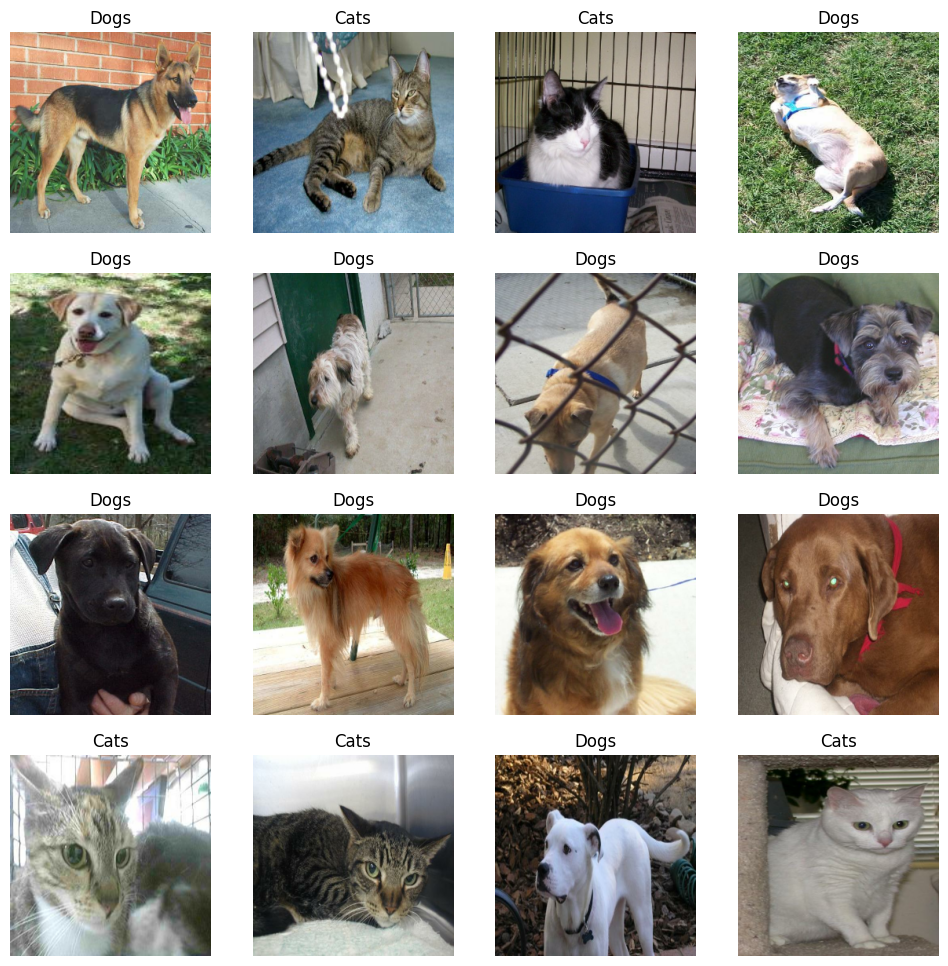

In [ ]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# Dataset Preparation

In [10]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
Validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

# Modeling

In [12]:
Model1 = tf.keras.Sequential([
    InputLayer(input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], padding = 'valid', activation = 'relu',  kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES'] *2),

    Conv2D(filters = CONFIGURATION['N_FILTERS']*2+4, kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], padding = 'valid', activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION["NUM_CLASSES"], activation = 'sigmoid')
])
Model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 16)      64        
 chNormalization)                                                
                                                        

# CallBacks

In [23]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of{}".format(batch+1, logs))

## CSV Logger

In [14]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

## Early Stopping

In [24]:
es_callback = EarlyStopping(
    monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1,
    mode = 'auto', baseline = None, restore_best_weights = False
)

## LearningRateScheduler

In [25]:
def scheduler(epoch, lr):
  if epoch <= 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

## Model Checkpoint

In [27]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.tf',
    monitor = 'val_loss',
    save_best_only = True,
)

## ReduceLROnPlateau

In [18]:
Plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,

)

# Model Training

In [28]:
metrics = [TruePositives(name ='tp'),FalsePositives(name ='fp'),
          BinaryAccuracy(name ='accuracy'),Precision(name ='precision'),Recall(name ='recall'),AUC(name = 'auc')]

In [29]:
Model1.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = metrics)

In [34]:
history=Model1.fit(
    training_dataset,
    validation_data = Validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks = ([checkpoint_callback], [scheduler_callback],[Plateau_callback],[es_callback],[csv_callback], [LossCallback()])
)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100

 For Batch Number 1 the model has a loss of{'loss': 0.7099143862724304, 'tp': 21.0, 'fp': 12.0, 'accuracy': 0.640625, 'precision': 0.6363636255264282, 'recall': 0.65625, 'auc': 0.72412109375}
  1/251 [..............................] - ETA: 8:27 - loss: 0.7099 - tp: 21.0000 - fp: 12.0000 - accuracy: 0.6406 - precision: 0.6364 - recall: 0.6562 - auc: 0.7241
 For Batch Number 2 the model has a loss of{'loss': 0.5542566776275635, 'tp': 49.0, 'fp': 17.0, 'accuracy': 0.75, 'precision': 0.7424242496490479, 'recall': 0.765625, 'auc': 0.80615234375}
  2/251 [..............................] - ETA: 15s - loss: 0.5543 - tp: 49.0000 - fp: 17.0000 - accuracy: 0.7500 - precision: 0.7424 - recall: 0.7656 - auc: 0.8062 
 For Batch Number 3 the model has a loss of{'loss': 0.5130268931388855, 'tp': 73.0, 'fp': 25.0, 'accuracy': 0.75, 'precision': 0.7448979616165161, 'recall': 0.7604166865348816, 'auc': 0.828721761

In [35]:
Model1.evaluate(Validation_dataset)

64/64 [==============================] - 3s 42ms/step - loss: 0.8624 - tp: 1440.0000 - fp: 572.0000 - accuracy: 0.7145 - precision: 0.7157 - recall: 0.7118 - auc: 0.7915


[0.8624288439750671,
 1440.0,
 572.0,
 0.7145328521728516,
 0.7157057523727417,
 0.7118141651153564,
 0.791477382183075]

# Plots

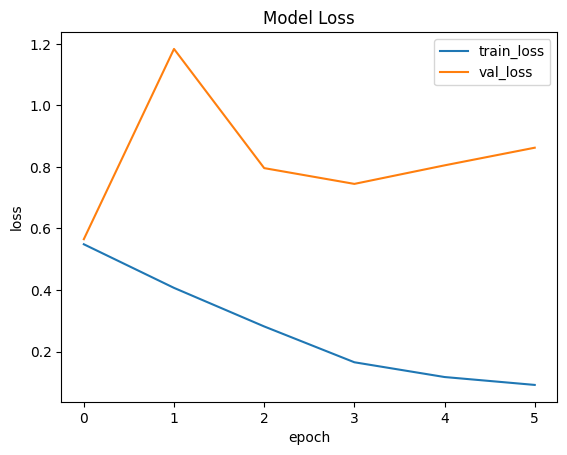

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

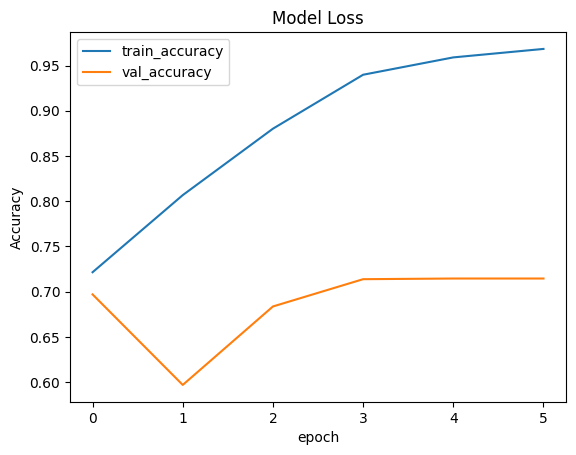

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show

# Testing

cats


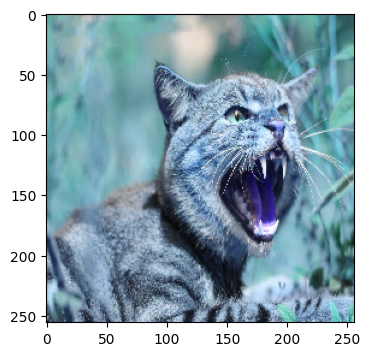

In [39]:
test_image = cv2.imread("/content/Andrew-Cooke-Feral-cat2.jpg")
test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(Model1(im), axis = -1).numpy()[0]])

cats


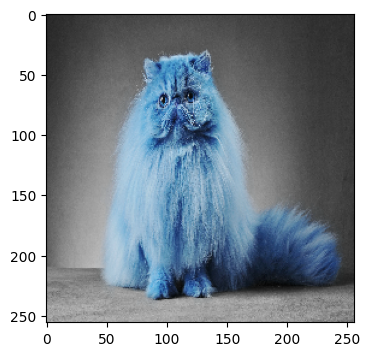

In [40]:
test_image = cv2.imread("/content/GettyImages-174770333-0f52afc06a024c478fafb1280c1f491f.jpg")
test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(Model1(im), axis = -1).numpy()[0]])

dogs


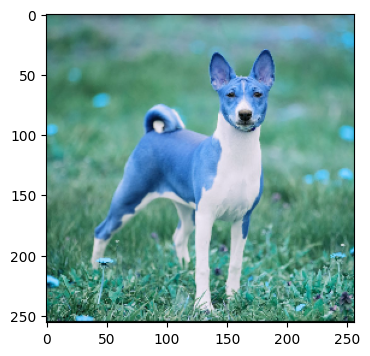

In [41]:
test_image = cv2.imread("/content/dog-breeds-that-are-like-cats-basenji-1581448671.jpg")
test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(Model1(im), axis = -1).numpy()[0]])

cats


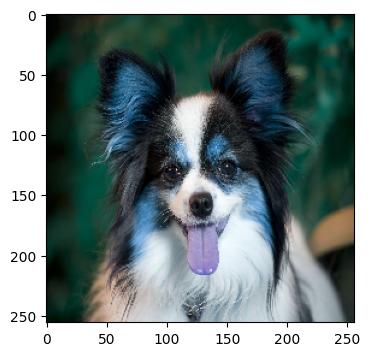

In [42]:
test_image = cv2.imread("/content/dog-breeds-that-are-like-cats-papillon-1581448671.jpg")
test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(Model1(im), axis = -1).numpy()[0]])

dogs


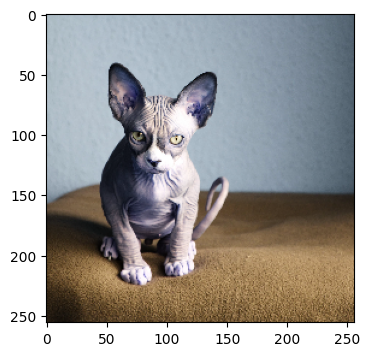

In [43]:
test_image = cv2.imread("/content/cats-that-act-like-dogs-sphinx-1564435135.jpg")
test_image = cv2.resize(test_image, (256, 256))

plt.figure(figsize = (4, 4))
plt.imshow(test_image)

test_image = tf.cast(test_image, tf.float32)
im = tf.expand_dims(test_image, axis = 0)
print(CLASS_NAMES[tf.argmax(Model1(im), axis = -1).numpy()[0]])